In [1]:
from bbSearch import SearchProblem, search,thecost
import math

Loading bbSearch Version 2.1 (at 21:58, Thu 20 Mar)
Last module source code edit 9am Thursday 24th Feb 2022


In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from copy import deepcopy

plt.ioff()  ## Turn off immediate display of plots

COLORS = ["lightgray", "red", "blue", "green", "yellow",
          "orange", "purple", "pink", "brown"]

class BlockState:

      # Specify mapping from directions to grid coordinate offsets:
      neighbour_offset = {"left": (0,-1), "right": (0,+1), "down":(+1,0), "up":(-1,0)}

      def __init__( self, blockstate, colors=COLORS ):
        self.blockstate = blockstate
        self.nrows = len(blockstate)
        self.ncols = len(blockstate[0])
        self.blocknums = set().union(*[set(row) for row in blockstate])
        self.blocknums = self.blocknums - {0}
        self.blocknumlist = list(self.blocknums)
        self.colors = colors

      def __repr__(self):
        return( str( self.blockstate ))

      # Find the cells occupied by a given number
      def blockcells( self, blocknum ):
          blockcells = []
          for row in range(self.nrows):
            for col in range(self.ncols):
              if self.blockstate[row][col] == blocknum:
                blockcells.append((row,col))
          return blockcells

      # Test if a cell is free (unblocked) in a given direction
      # Free if not blocked by edge of grid or by a cell of different colour
      def free_cell( self, direction, cell ):
        row, col = cell
        offrow, offcol = BlockState.neighbour_offset[direction]
        neighrow, neighcol = (row + offrow, col + offcol)
        if not (0 <= neighrow < self.nrows): return False #at top or bottom
        if not (0 <= neighcol < self.ncols): return False #at left or right
        neighval = self.blockstate[neighrow][neighcol]
        # Neighboring cell must be empty or part of the same coloured block
        return  (neighval==0 or neighval==self.blockstate[row][col])

      def free_block( self, direction, blockn ):
          blockcells = self.blockcells(blockn)
          for cell in blockcells:
            if not self.free_cell(direction, cell):
              return False
          return True

      def possible_moves(self):
        moves = []
        for blocknum in self.blocknumlist:
          for direction in ["left", "right", "down", "up"]:
              if self.free_block(direction, blocknum):
                  moves.append((blocknum, direction))
        return moves

      def next_state(self, move):
          next_blockstate = deepcopy(self.blockstate)
          blockno, direction = move
          cells = self.blockcells(blockno)
          ## first clear all cells of the block (set to 0)
          for cell in cells:
            row, col = cell
            next_blockstate[row][col] = 0
          rowoff, coloff = BlockState.neighbour_offset[direction]
          ## now set all neighbour cells (in move direction) to be
          ## cells with the blocknumber
          for cell in cells:
            row, col = cell
            next_blockstate[row+rowoff][col+coloff] = blockno
          return BlockState(next_blockstate)

      def color_key(self):
          return {b:self.colors[b] for b in self.blocknumlist}

      def figure(self, scale=0.5):
          nrows = self.nrows
          ncols = self.ncols
          fig, ax = plt.subplots(figsize=(ncols*scale+0.1,nrows*scale+0.1))
          plt.close(fig)
          ax.set_axis_off() # Don't show border lines and coordinate values

          frame = patches.Rectangle((0,0),1,1, linewidth=5, edgecolor='k', facecolor='w')
          ax.add_patch(frame)

          for row in range(nrows):
            for col in range(ncols):
                greyrect = patches.Rectangle( (((col*0.9)/ncols)+0.05,
                                               (((nrows-row-1)*0.9)/nrows)+0.05 ),
                                            0.9/ncols, 0.9/nrows,
                                            linewidth=1, edgecolor="gray", facecolor="lightgray")
                ax.add_patch(greyrect)

          for row in range(nrows):
            for col in range(ncols):
                cellval = self.blockstate[row][col]
                if cellval > 0:
                  cellcol = COLORS[cellval]
                  rect = patches.Rectangle( (((col*0.9)/ncols)+0.05,
                                             (((nrows-row-1)*0.9)/nrows)+0.05 ),
                                            0.9/ncols, 0.9/nrows,
                                            linewidth=0, edgecolor=cellcol, facecolor=cellcol)
                  ax.add_patch(rect)
          return fig

      def display(self):
          display(self.figure())

In [3]:
from copy import deepcopy
class SlidingBlocksPuzzle( SearchProblem ):

    def __init__( self, initial_state, goal, colors=COLORS ):
        """
        The __init__ method must set the initial state for the search.
        Arguments could be added to __init__ and used to configure the
        initial state and/or other aspects of a problem instance.
        """
        self.initial_state = BlockState(initial_state, colors=colors)
        self.colors = colors
        self.goal = BlockState(goal)

    def info(self):
        print("Solve the following sliding blocks problem.")
        print("Get from this initial state:")
        self.initial_state.display()
        print("To a state incorporating the following block position(s):")
        self.goal.display()
        print("You need to slide the red block to cover the bottom right square.")

    def possible_actions(self, state):
        return state.possible_moves()

    def successor(self, state, action):
        """
        This takes a state and an action and returns the new state resulting
        from doing that action in that state. You can assume that the given
        action is in the list of 'possible_actions' for that state.
        """
        return state.next_state(action)

    def goal_test(self, state):
        """
        For the sliding blocks puzzles, the goal condition is reached when
        all block possitions specified in the given goal state are satisfied by
        the current state. But empty positions (ie 0s) in the goal are ignored,
        so can be occupied by blocks in the current sate.
        """
        for row in range(state.nrows):
          for col in range(state.ncols):
            goalnum = self.goal.blockstate[row][col]
            if goalnum==0:
              continue
            if goalnum != state.blockstate[row][col]:
              return False
        return True


    def cost(self, path, state):
        """
        This is an optional method that you only need to define if you are using
        a cost based algorithm such as "uniform cost" or "A*". It should return
        the cost of reaching a given state via a given path.
        If this is not re-defined, it will is assumed that each action costs one unit
        of effort to perform, so it returns the length of the path.
        """
        return len(path)

    def display_action(self, action):
        """
        You can set the way an action will be displayed in outputs.
        """
        print((self.colors[action[0]], action[1]))

    def display_state(self, state):
        """
        You can set the way a state will be displayed in outputs.
        """
        state.display()

    def display_state_path( self, actions ):
        """
        This defines output of a solution path when a list of actions
        is applied to the initial state. It assumes it is a valid path
        with all actions being possible in the preceeding state.
        You probably don't need to override this.
        """
        s = self.initial_state
        self.display_state(s)
        for a in actions:
            self.display_action(a)
            s = self.successor(s,a)
            self.display_state(s)

In [4]:
def compute_anchor_points(state):
    anchor_points = {}  # 存储每个滑块的“锚点”位置
    block_positions = {}  # 记录滑块所有单元格的位置

    for r, row in enumerate(state.blockstate):
        for c, col in enumerate(row):
            if col != 0:  # 如果是滑块
                if col not in block_positions:
                    block_positions[col] = []
                block_positions[col].append((r, c))

    # 计算每个滑块的锚点
    for block, positions in block_positions.items():
        # 方案 1: 选择左上角作为锚点
        r_min, c_min = min(positions)

        # 方案 2: 计算几何中心（平均坐标）
        r_avg = sum(p[0] for p in positions) // len(positions)
        c_avg = sum(p[1] for p in positions) // len(positions)

        anchor_points[block] = (r_min, c_min)  # 或者使用 `(r_avg, c_avg)`

    return anchor_points

In [5]:
# # 有锚点的曼哈顿
def manhattan_heuristic(state, goal_anchors):
    total_distance = 0
    state_anchors = compute_anchor_points(state)  # 计算当前状态的锚点

    for block, (r, c) in state_anchors.items():
        if block in goal_anchors:
            r_goal, c_goal = goal_anchors[block]
            total_distance += abs(r_goal - r) + abs(c_goal - c)  # 计算曼哈顿距离

    return total_distance*2  # 乘了2，因为原本的，加上cost后时间变短了，说明cost的影响过多

In [6]:
# 欧氏距离
def straight_line_distance(state,goal_anchors):
    total_distance = 0
    state_anchors = compute_anchor_points(state)
    
    for block, (r, c) in state_anchors.items():
        if block in goal_anchors:
            r_goal, c_goal = goal_anchors[block]
            total_distance += math.sqrt((r_goal - r) ** 2 + (c_goal - c) ** 2)
    return total_distance*2

## small_puzzle

In [7]:
small_initial = [[0,4,1,1],
                 [0,0,1,3],
                 [0,2,6,0],
                 [2,2,6,0]]

small_goal    = [[0,0,0,0],
                 [0,0,0,0],
                 [0,0,1,1],
                 [0,0,1,0]]
small_puzzle =  SlidingBlocksPuzzle( small_initial, small_goal )

Solve the following sliding blocks problem.
Get from this initial state:


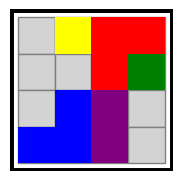

To a state incorporating the following block position(s):


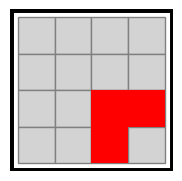

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=manhattan_heuristic
Max search nodes: 10000000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 8
Goal state is:


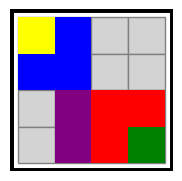

The action path to the solution is:
('blue', 'up')
('green', 'down')
('yellow', 'left')
('blue', 'up')
('purple', 'left')
('red', 'down')
('green', 'down')
('red', 'down')

The state/action path to the solution is:


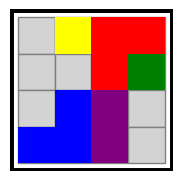

('blue', 'up')


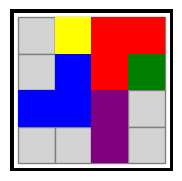

('green', 'down')


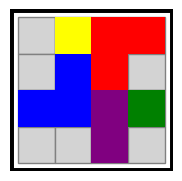

('yellow', 'left')


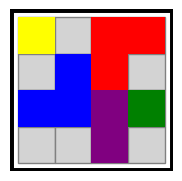

('blue', 'up')


KeyboardInterrupt: 

In [8]:
# greedy(Manhattan Distance) loop_check=True
clever_search = search( small_puzzle, 'BF/FIFO', 10000000, heuristic = manhattan_heuristic,
                     loop_check=True, randomise=False, show_state_path=True, return_info=True)

In [ ]:
# greedy(Manhattan Distance)  loop_check=False
clever_search = search( small_puzzle, 'BF/FIFO', 10000000, heuristic = manhattan_heuristic,
                     loop_check=False, randomise=False, show_state_path=True, return_info=True)

In [ ]:
# A*(Manhattan Distance) loop_check=True
clever_search = search( small_puzzle, 'BF/FIFO', 10000000, heuristic = manhattan_heuristic,
                     loop_check=True, randomise=False, cost=thecost, show_state_path=True, return_info=True)

In [ ]:
# A*(Manhattan Distance) loop_check=False
clever_search = search( small_puzzle, 'BF/FIFO', 10000000, heuristic = manhattan_heuristic,
                     loop_check=False, randomise=False, cost=thecost, show_state_path=True, return_info=True)

In [ ]:
# greedy(Euclidean Distance) loop_check=True
clever_search = search( small_puzzle, 'BF/FIFO', 10000000, heuristic = straight_line_distance,
                     loop_check=True, randomise=False, show_state_path=True, return_info=True)

In [ ]:
# greedy(Euclidean Distance) loop_check=False
clever_search = search( small_puzzle, 'BF/FIFO', 10000000, heuristic = straight_line_distance,
                     loop_check=False, randomise=False, show_state_path=True, return_info=True)

In [ ]:
# A*(Euclidean Distance) loop_check=True
clever_search = search( small_puzzle, 'BF/FIFO', 10000000, heuristic = straight_line_distance,
                     loop_check=True, randomise=False,cost=thecost, show_state_path=True, return_info=True)

In [ ]:
# A*(Euclidean Distance) loop_check=False
clever_search = search( small_puzzle, 'BF/FIFO', 10000000, heuristic = straight_line_distance,
                     loop_check=False, randomise=False,cost=thecost, show_state_path=True, return_info=True)

## middle

In [ ]:
big   = [[1,3,0,0,0,6,6],
         [1,3,4,4,0,0,0],
         [3,3,4,0,0,0,0],
         [0,4,4,2,2,5,0],
         [0,0,2,2,5,5,0]]

hard_goal   = [[6,6,2,2,0,0,0],
               [0,2,2,0,0,0,0],
               [0,0,0,0,0,0,0],
               [0,0,0,0,0,0,1],
               [0,0,0,0,0,0,1]]

hard_puzzle =  SlidingBlocksPuzzle( big, hard_goal )

In [ ]:
# 1.greedy(Manhattan Distance) loop_check=True
clever_search = search( hard_puzzle, 'BF/FIFO', 10000000, heuristic = manhattan_heuristic,
                     loop_check=True, randomise=False, show_state_path=True, return_info=True)

In [ ]:
# 2.greedy(Manhattan Distance) loop_check=False
clever_search = search( hard_puzzle, 'BF/FIFO', 10000000, heuristic = manhattan_heuristic,
                     loop_check=False, randomise=False, show_state_path=True, return_info=True)

In [ ]:
# 3A*(Manhattan Distance) loop_check=True
clever_search = search( hard_puzzle, 'BF/FIFO', 10000000, heuristic = manhattan_heuristic,
                     loop_check=True, randomise=False,cost=thecost, show_state_path=True, return_info=True)

In [ ]:
# 4A*(Manhattan Distance) loop_check=False
clever_search = search( hard_puzzle, 'BF/FIFO', 10000000, heuristic = manhattan_heuristic,
                     loop_check=False, randomise=False,cost=thecost, show_state_path=True, return_info=True)

In [ ]:
# 5greedy(Euclidean Distance) loop_check=True
clever_search = search( hard_puzzle, 'BF/FIFO', 10000000, heuristic = straight_line_distance,
                     loop_check=True, randomise=False, show_state_path=True, return_info=True)

In [ ]:
# 6greedy(Euclidean Distance) loop_check=False
clever_search = search( hard_puzzle, 'BF/FIFO', 10000000, heuristic = straight_line_distance,
                     loop_check=False, randomise=False, show_state_path=True, return_info=True)

In [ ]:
# 7A*(欧式Distance) loop_check=True
clever_search = search( hard_puzzle, 'BF/FIFO', 10000000, heuristic = straight_line_distance,
                     loop_check=True, randomise=False,cost=thecost, show_state_path=True, return_info=True)

In [ ]:
# 5A*(欧式Distance) loop_check=False
clever_search = search( hard_puzzle, 'BF/FIFO', 10000000, heuristic = straight_line_distance,
                     loop_check=False, randomise=False,cost=thecost, show_state_path=True, return_info=True)

## hard

In [ ]:
most_big = [
    [1, 3, 0, 0, 0, 0, 0, 7],
    [1, 3, 4, 4, 0, 0, 6, 7],
    [3, 3, 4, 0, 8, 8, 6, 0],
    [0, 4, 4, 0, 0, 8, 0, 0],
    [0, 5, 0, 0, 0, 3, 0, 5],
    [0, 5, 2, 2, 3, 3, 3, 5],
    [5, 5, 0, 2, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0]
]

most_big_goal = [
    [5, 0, 0, 0, 0, 0, 0, 0],
    [5, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 1]
]

most_big_puzzle = SlidingBlocksPuzzle(most_big, most_big_goal)

In [ ]:
clever_search_hardest = search( most_big_puzzle, 'BF/FIFO', 1000000, heuristic=manhattan_heuristic,
                     loop_check=True, randomise=False, show_state_path=True, return_info=True)

In [ ]:
clever_search_hardest = search( most_big_puzzle, 'BF/FIFO', 10000000, heuristic = manhattan_heuristic,
                     loop_check=True, randomise=False,cost=thecost, show_state_path=True, return_info=True)

In [ ]:
clever_search_hardest = search( most_big_puzzle, 'BF/FIFO', 10000000, heuristic = straight_line_distance,
                     loop_check=True, randomise=False, show_state_path=True, return_info=True)

In [ ]:
clever_search_hardest = search( most_big_puzzle, 'BF/FIFO', 10000000, heuristic = straight_line_distance,
                     loop_check=True, randomise=False,cost=thecost, show_state_path=True, return_info=True)

In [ ]:
import threading
def target():
        result[0] = clever_search_hardest = search( most_big_puzzle, 'BF/FIFO', 10000000, heuristic = straight_line_distance,
                     loop_check=True, randomise=False,cost=thecost, show_state_path=True, return_info=True)
thread = threading.Thread(target=target)
thread.start()
thread.join(timeout=300) 
if thread.is_alive():  
    print("The search times out")
else 
    result[0]